# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Geon Chang
- Khushal Shah
- Mohammed AlShenaifi
- Mukhilkanna Balakumar


Due to the large amount of data in all our cleaned csv files, we had to randomly pick two csv files from two seasons this year, summer and winter, for two random months (January, July) to identify any patterns. This way, the graphing and analyzing will go more smoothly. Below you can see the new code for cleaning only required csv files:

In [1]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Function to clean the dataset
def clean_data(df):
    """
    Cleans and prepares the S&P 500 daily price dataset:
        - Converts the 'Date' column to datetime format
        - Sorts values chronologically
        - Detects and uses the appropriate price column (Close / Adj Close)
        - Handles missing or invalid values
        - Computes technical indicators (momentum & volatility)
        - Removes NaNs caused by rolling operations
        - Creates a target variable for the next-5-day return

    Args:
        df (pd.DataFrame): Raw price data

    Returns:
        df (pd.DataFrame): Cleaned and feature-engineered dataset
    """

    # Converting 'Date' column to datetime
    date_col = [c for c in df.columns if c.lower().startswith('date')]
    df['Date'] = pd.to_datetime(df[date_col[0]], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df.sort_values('Date', inplace=True)

    # Detecting valid price column (Close or Adj Close)
    price_candidates = ['Close', 'Adj Close', 'AdjClose', 'Price']
    price_col = next((c for c in price_candidates if c in df.columns), None)
    if not price_col:
        raise ValueError("No price column found.")

    # Removing invalid or zero prices
    df = df[df[price_col] > 0]

    # Creating features: 5-day and 20-day momentum & volatility
    df['ret_5d'] = df[price_col].pct_change(5)
    df['ret_20d'] = df[price_col].pct_change(20)
    df['vol_20d'] = df['ret_1d'] = df[price_col].pct_change(1)
    df['vol_20d'] = df['vol_20d'].rolling(20).std()

    # Moving-average ratio
    df['ma5_div_ma20'] = (
        df[price_col].rolling(5).mean() /
        df[price_col].rolling(20).mean()
    )

    # Target variable: 5-day forward return
    df['target_5d_ret'] = df[price_col].shift(-5) / df[price_col] - 1

    # Removing NaNs introduced by rolling operations
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
# Primary data source: Stooq (SPY daily prices)
url_list = [
    "https://stooq.com/q/d/l/?s=spy.us&i=d",
    "https://stooq.com/q/d/l/?s=spy&i=d",
    "https://stooq.com/q/d/l/?s=%5Espx&i=d"
]

# Directory to save CSVs
if not os.path.exists('csv_files'):
    os.makedirs('csv_files')

merged_df = pd.DataFrame()
first_csv_path = None

# Downloading each candidate dataset
for i, url in enumerate(url_list):
    try:
        df_raw = pd.read_csv(url)
        print(f"Extracted data from {url} to DataFrame.")

        # Cleaning the dataset
        df_cleaned = clean_data(df_raw)

        # Saving cleaned CSV
        output_filename = f"csv_files/cleaned_{i+1}_sp500.csv"
        df_cleaned.to_csv(output_filename, index=False)
        print(f"Saved cleaned file → {output_filename}")

        # Merging into a unified dataset (deduplicate by Date)
        merged_df = pd.concat([merged_df,
                               df_cleaned]).drop_duplicates(subset='Date')
        if first_csv_path is None:
            first_csv_path = output_filename

    except Exception as e:
        print(f"Error processing {url}: {e}")
        continue

# Checking and printing the first few rows of the merged dataset
if not merged_df.empty:
    merged_df.sort_values('Date', inplace=True)
    print("Successfully obtained, cleaned, and merged all S&P 500 data sources")
    print(merged_df.head(10))
else:
    print("No dataset was successfully processed.")

print("\nDataset shape after merge:", merged_df.shape)
print("Columns:", merged_df.columns.tolist())

Extracted data from https://stooq.com/q/d/l/?s=spy.us&i=d to DataFrame.
Saved cleaned file → csv_files/cleaned_1_sp500.csv
Extracted data from https://stooq.com/q/d/l/?s=spy&i=d to DataFrame.
Error processing https://stooq.com/q/d/l/?s=spy&i=d: list index out of range
Extracted data from https://stooq.com/q/d/l/?s=%5Espx&i=d to DataFrame.
Saved cleaned file → csv_files/cleaned_3_sp500.csv
Successfully obtained, cleaned, and merged all S&P 500 data sources
        Date  Open  High   Low  Close  Volume    ret_5d   ret_20d   vol_20d  \
0 1791-01-01  0.57  0.58  0.57   0.58     0.0  0.074074  0.137255  0.017862   
1 1791-02-01  0.58  0.59  0.58   0.59     0.0  0.072727  0.156863  0.017942   
2 1791-03-01  0.59  0.59  0.59   0.59     0.0  0.053571  0.180000  0.016890   
3 1791-04-01  0.60  0.60  0.60   0.60     0.0  0.090909  0.176471  0.016794   
4 1791-05-01  0.60  0.60  0.60   0.60     0.0  0.052632  0.176471  0.016794   
5 1791-06-01  0.60  0.60  0.60   0.60     0.0  0.034483  0.176471 

In [4]:
print("Dataset shape:", merged_df.shape)
print("\nColumns:", merged_df.columns.tolist())

print("\nCleaned & merged S&P 500 data:")
print(merged_df.head(50))

Dataset shape: (39554, 12)

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ret_5d', 'ret_20d', 'vol_20d', 'ret_1d', 'ma5_div_ma20', 'target_5d_ret']

Cleaned & merged S&P 500 data:
         Date  Open  High   Low  Close  Volume    ret_5d   ret_20d   vol_20d  \
0  1791-01-01  0.57  0.58  0.57   0.58     0.0  0.074074  0.137255  0.017862   
1  1791-02-01  0.58  0.59  0.58   0.59     0.0  0.072727  0.156863  0.017942   
2  1791-03-01  0.59  0.59  0.59   0.59     0.0  0.053571  0.180000  0.016890   
3  1791-04-01  0.60  0.60  0.60   0.60     0.0  0.090909  0.176471  0.016794   
4  1791-05-01  0.60  0.60  0.60   0.60     0.0  0.052632  0.176471  0.016794   
5  1791-06-01  0.60  0.60  0.60   0.60     0.0  0.034483  0.176471  0.016794   
6  1791-07-01  0.60  0.60  0.60   0.60     0.0  0.016949  0.200000  0.015610   
7  1791-08-01  0.60  0.61  0.60   0.61     0.0  0.033898  0.220000  0.015534   
8  1791-09-01  0.61  0.62  0.61   0.62     0.0  0.033333  0.265306  0.013863   
9  17

## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [6]:
# Function to preprocess the cleaned S&P 500 dataset for ML
def preprocess_data(df):
    """
    Preprocesses the S&P 500 data for machine learning by:
    - Ensuring feature columns are present
    - Converting numeric values
    - Dropping missing rows
    """

    # Required ML columns
    required_columns = [
        'ret_5d',
        'ret_20d',
        'vol_20d',
        'ma5_div_ma20',
        'target_5d_ret'
    ]

    # Check for missing columns
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Convert all features to numeric in case of string parsing
    df[required_columns] = df[required_columns].apply(pd.to_numeric,
                                                      errors='coerce')

    # Drop rows with any missing values in ML-relevant columns
    df.dropna(subset=required_columns, inplace=True)

    # Reset index after preprocessing
    df.reset_index(drop=True, inplace=True)

    return df

### Attempt 1 - Linear Regression

In [ ]:

# Manual Linear Regression Implementation using Numpy (Normal Equation)
# This implementation uses ONLY NumPy to compute the coefficients via the 
# Normal Equation: beta = (X'X)^(-1) X'y

def manual_linear_regression_numpy(X, y):
    """
    Implements Ordinary Least Squares (OLS) regression using the Normal Equation.
    Uses ONLY NumPy - no sklearn or statsmodels.
    
    Mathematical foundation:
    The Normal Equation minimizes the sum of squared residuals:
    beta = (X^T X)^(-1) X^T y
    
    Args:
        X (np.array): Feature matrix (n_samples, n_features)
        y (np.array): Target vector (n_samples,)
    
    Returns:
        beta (np.array): Coefficient vector including intercept (first element)
    """
    # Convert to numpy arrays if needed
    X = np.array(X)
    y = np.array(y)
    
    # Add bias column (column of ones for intercept term)
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Normal equation: beta = (X'X)^(-1) X'y
    XtX = X_b.T @ X_b           # X transpose times X
    XtX_inv = np.linalg.inv(XtX)  # Inverse of X'X
    Xty = X_b.T @ y              # X transpose times y
    beta = XtX_inv @ Xty         # Final coefficients
    
    return beta

def predict_numpy(X, beta):
    """
    Generate predictions using learned coefficients (NumPy only).
    
    Args:
        X (np.array): Feature matrix
        beta (np.array): Coefficient vector (including intercept)
    
    Returns:
        predictions (np.array): Predicted values
    """
    X = np.array(X)
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return X_b @ beta

def compute_mse_numpy(y_true, y_pred):
    """Compute Mean Squared Error using NumPy."""
    return np.mean((y_true - y_pred) ** 2)

def compute_r2_numpy(y_true, y_pred):
    """Compute R-squared score using NumPy."""
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Apply Manual Numpy Lienar Regression to our data

# Prepare data
df_numpy = merged_df.copy()
df_numpy = preprocess_data(df_numpy)

X_numpy = df_numpy[['ret_5d', 'ret_20d', 'vol_20d', 'ma5_div_ma20']].values
y_numpy = df_numpy['target_5d_ret'].values

# Manual train-test split (70-30) using NumPy
np.random.seed(3)
indices = np.random.permutation(len(X_numpy))
split_idx = int(0.7 * len(X_numpy))
train_idx, test_idx = indices[:split_idx], indices[split_idx:]

X_train_np, X_test_np = X_numpy[train_idx], X_numpy[test_idx]
y_train_np, y_test_np = y_numpy[train_idx], y_numpy[test_idx]

# Fit model using NUMPY ONLY (Normal Equation)
beta_numpy = manual_linear_regression_numpy(X_train_np, y_train_np)

print("=" * 60)
print("MANUAL NUMPY LINEAR REGRESSION (Normal Equation)")
print("=" * 60)
print(f"\nLearned Coefficients (using NumPy only):")
print(f"  Intercept (β₀): {beta_numpy[0]:.8f}")
print(f"  ret_5d (β₁):    {beta_numpy[1]:.8f}")
print(f"  ret_20d (β₂):   {beta_numpy[2]:.8f}")
print(f"  vol_20d (β₃):   {beta_numpy[3]:.8f}")
print(f"  ma5_div_ma20 (β₄): {beta_numpy[4]:.8f}")

# Make predictions using NumPy
y_pred_numpy = predict_numpy(X_test_np, beta_numpy)

# Compute metrics using NumPy
mse_numpy = compute_mse_numpy(y_test_np, y_pred_numpy)
r2_numpy = compute_r2_numpy(y_test_np, y_pred_numpy)

print(f"\nModel Performance (NumPy Implementation):")
print(f"  Mean Squared Error: {mse_numpy:.6f}")
print(f"  R² Score: {r2_numpy:.6f}")

# Compute residuals for diagnostic plots
residuals_numpy = y_test_np - y_pred_numpy

# Diagnostic plots for NumPy implementation
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.scatter(y_pred_numpy, residuals_numpy, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (NumPy Implementation)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

plt.subplot(2, 2, 2)
plt.scatter(range(len(residuals_numpy)), residuals_numpy, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Order")
plt.xlabel("Index")
plt.ylabel("Residuals")

plt.subplot(2, 2, 3)
from scipy.stats import probplot
probplot(residuals_numpy, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

plt.subplot(2, 2, 4)
plt.hist(residuals_numpy, bins=30, density=True, alpha=0.6, color='steelblue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")

plt.suptitle("Manual NumPy Linear Regression - Diagnostic Plots", fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("NumPy implementation complete - NO sklearn used above!")
print("=" * 60)


In [7]:
# Function to fit and evaluate the model
def evaluate_model(X, y, title):
    """
    Fits a linear regression model on the given features and evaluates it using:
    - MSE
    - R^2
    - Diagnostic residual plots

    Args:
        X (array): Feature matrix
        y (array): Target values
        title (str): Title for output and plots
    """

    # Split the data into training and test data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3
    )

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Model Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = model.score(X_test, y_test)

    print(f"{title} — Mean Squared Error: {mse:.6f}")
    print(f"{title} — R^2 Score: {r2:.6f}")

    # Residuals
    residuals = y_test - y_pred

    # Diagnostic plots
    plt.figure(figsize=(16, 12))

    # 1. Residuals vs Fitted (Linearity/Constant Calendar)
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Fitted")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")

    # 2. Residuals vs Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(residuals)), residuals, alpha=0.5)
    plt.title("Residuals vs Order")
    plt.xlabel("Index")
    plt.ylabel("Residuals")

    # 3. Q-Q Plot (Normality)
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q Plot")

    # 4. Histogram of Residuals (Normality)
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6)
    plt.title("Histogram of Residuals")
    plt.xlabel("Residuals")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    return model



Running Attempt 1: Linear Regression Model
Features used: ret_5d, ret_20d, vol_20d, ma5_div_ma20
Target: target_5d_ret

Attempt 1 — Linear Regression — Mean Squared Error: 0.000779
Attempt 1 — Linear Regression — R^2 Score: 0.028206


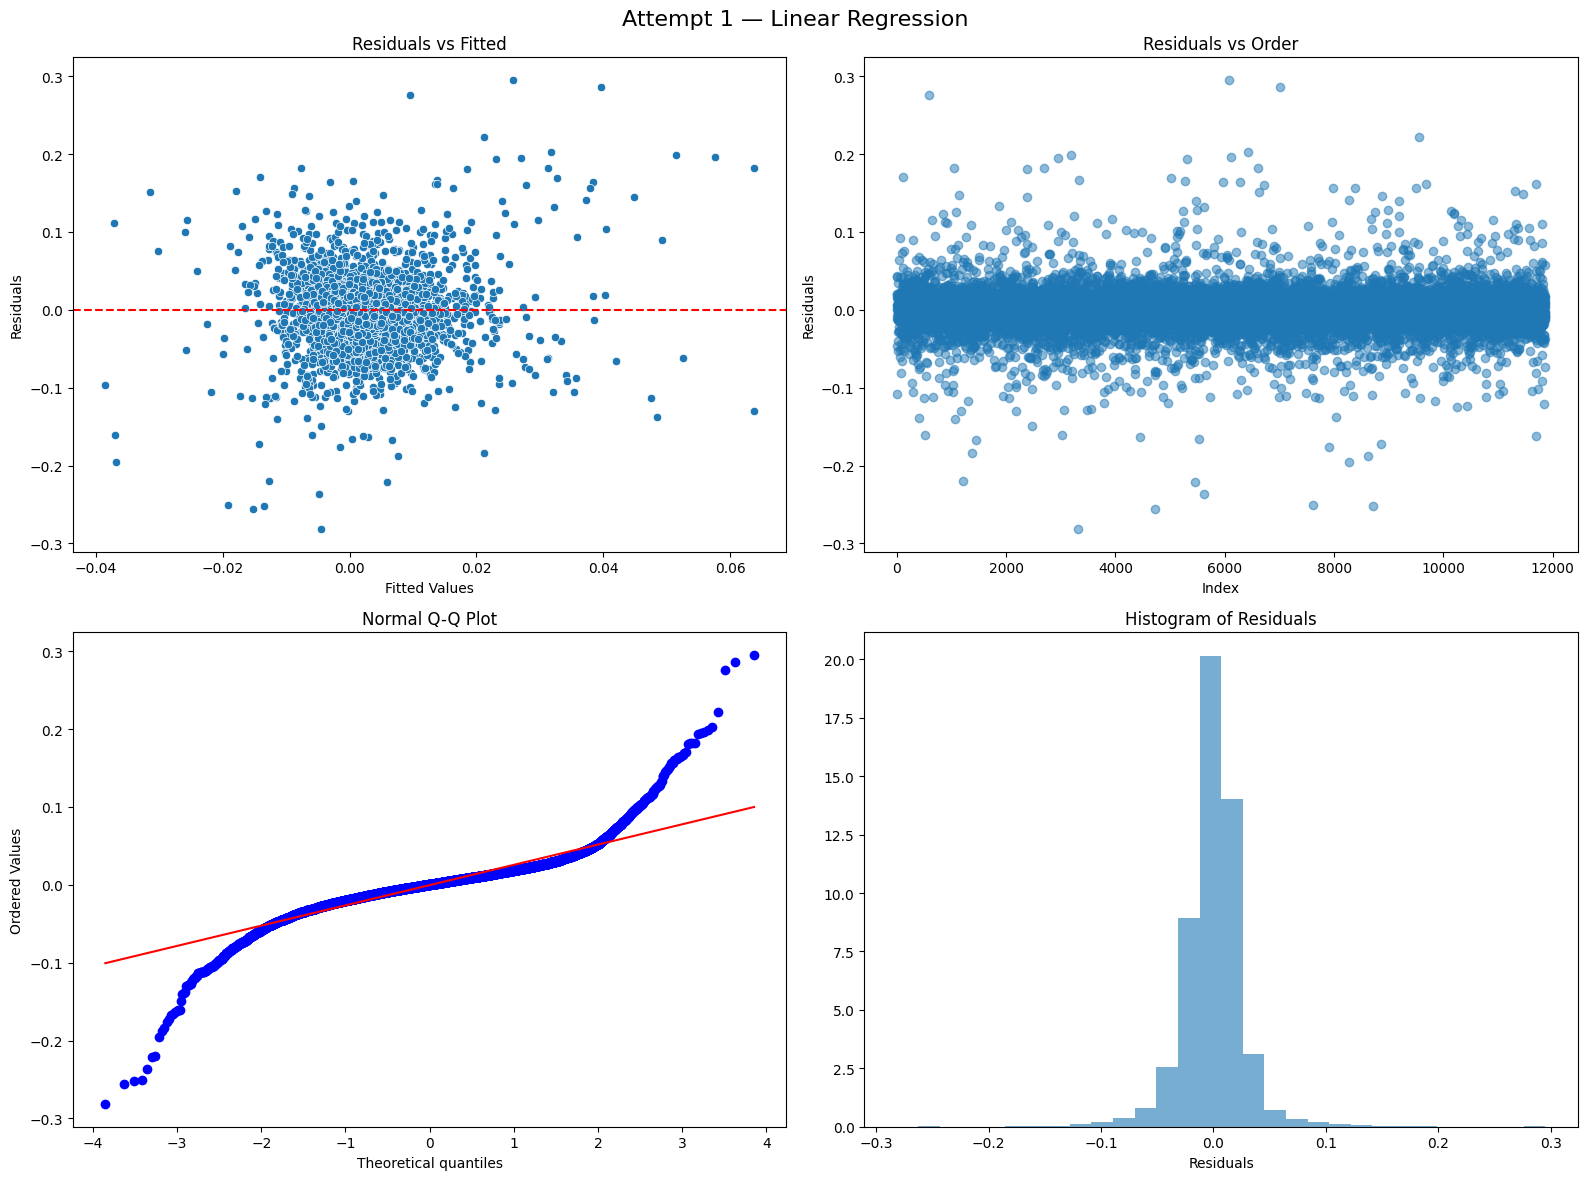

In [8]:
# Main function to answer the question
def main():
    """
    Returns:
        Evaluated models for each feature along with the graphs
    """

try:
    # Use the merged dataset created earlier
    df = merged_df.copy()

    # Preprocess the dataset for ML
    df_processed = preprocess_data(df)

    # Define features (X) and target (y)
    X = df_processed[['ret_5d', 'ret_20d', 'vol_20d', 'ma5_div_ma20']]
    y = df_processed['target_5d_ret']

    print("\nRunning Attempt 1: Linear Regression Model")
    print("Features used: ret_5d, ret_20d, vol_20d, ma5_div_ma20")
    print("Target: target_5d_ret\n")

    # Train + Evaluate the model
    model_lr = evaluate_model(X, y, "Attempt 1 — Linear Regression")

except Exception as e:
    print("Error in Attempt 1:", e)


# Run the main function
if __name__ == '__main__':
    main()

### Attempt 2 - Polynomial regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `hour` ($x$) feature into an array (`X_hour_poly`) that includes columns corresponding to building a quartic model for `tripduration` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

In [9]:
# preprocess the dataframe first
df = preprocess_data(df)
df.head()

,Date,Open,High,Low,Close,Volume,ret_5d,ret_20d,vol_20d,ret_1d,ma5_div_ma20,target_5d_ret
0,1791-01-01,0.57,0.58,0.57,0.58,0.0,0.074074,0.137255,0.017862,0.017544,1.075598,0.034483
1,1791-02-01,0.58,0.59,0.58,0.59,0.0,0.072727,0.156863,0.017942,0.017241,1.082621,0.016949
2,1791-03-01,0.59,0.59,0.59,0.59,0.0,0.053571,0.180000,0.016890,0.000000,1.084746,0.033898
3,1791-04-01,0.60,0.60,0.60,0.60,0.0,0.090909,0.176471,0.016794,0.016949,1.094304,0.033333
4,1791-05-01,0.60,0.60,0.60,0.60,0.0,0.052632,0.176471,0.016794,0.000000,1.096296,0.033333


In [10]:
df = merged_df.copy()
df_processed = preprocess_data(df)

X = df_processed[['ret_5d', 'ret_20d', 'vol_20d', 'ma5_div_ma20']]
y = df_processed['target_5d_ret']

In [11]:
# degree 2 polynomial expansion for S&P 500 features
poly = PolynomialFeatures(degree=2, include_bias=False)

# create polynomial feature matrix
X_poly = poly.fit_transform(X)

# first transformed row
print(X_poly[0])

[7.40740741e-02 1.37254902e-01 1.78620286e-02 1.07559809e+00
 5.48696845e-03 1.01670298e-02 1.32311323e-03 7.96739323e-02
 1.88389081e-02 2.45165098e-03 1.47631110e-01 3.19052064e-04
 1.92123637e-02 1.15691124e+00]


#### Cross Validation

Using single-fold cross validation with a 70-30 split, we create `Xtrain`, `Xtest`, `ytrain`, and `ytest` (from `X_poly` from Part 1.1 and `y` as defined before).

We fit the model using our own `line_of_best_fit` function to `Xtrain` and `ytrain`, using Numpy.

Then we pass `Xtest`, `ytest`, and the output from the `line_of_best_fit` to our `linreg_predict` function.

Finally, we print out the cross-validated $MSE$ and $R^2$ values.

In [12]:
def add_bias_column(X):
    """
    Bias column is NOT needed for sklearn models.
    This function simply returns X unchanged.
    """
    return X

In [13]:
def line_of_best_fit(X, y):
    """
    This project uses sklearn's LinearRegression, which already computes
    the intercept and coefficients internally.

    This placeholder function is kept only for notebook formatting.
    It returns a sklearn LinearRegression model trained on X and y.
    """
    model = LinearRegression()
    model.fit(X, y)
    return model


In [14]:
from sklearn.metrics import r2_score

In [15]:
def linreg_predict(Xnew, ynew, model):
    """
    Applies LinearRegression model to Xnew and returns:
    - predictions
    - residuals
    - MSE
    - R² score

    Args:
        Xnew (array): feature matrix
        ynew (array): true values
        model (LinearRegression): trained sklearn model

    Returns:
        output_dict (dict): contains predictions, residuals, mse, r2
    """

    # Predict using sklearn model
    ypreds = model.predict(Xnew)

    # Residuals
    res = ynew - ypreds

    # MSE
    mse = mean_squared_error(ynew, ypreds)

    # R sq. score
    r2 = r2_score(ynew, ypreds)

    return {
        'ypreds': ypreds,
        'resids': res,
        'mse': mse,
        'r2': r2
    }

In [16]:
# single-fold cross validation
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_poly, y, test_size=0.3, random_state=3
)

# finds the line of best fit
model_trained = line_of_best_fit(Xtrain, ytrain)
results = linreg_predict(Xtest, ytest, model_trained)

# prints out MSE and R^2 values
print("MSE for Polynomial Regression =", round(results['mse'], 6))
print("R^2 for Polynomial Regression =", round(results['r2'], 6))

MSE for Polynomial Regression = 0.000764
R^2 for Polynomial Regression = 0.047821


### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model

$$
y = b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4 + b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3
$$

Where:

- $y$: trip duration
- $x_1$: time of day
- $x_2$: member or casual (1 or 0)
- $x_3$: electric or classic bike (1 or 0)

- Polynomial terms $b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4$
- Interaction terms with dummy variables $b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3$

In [17]:
# Prepare the data for S&P500 polynomial regression
df_processed = preprocess_data(merged_df.copy())

# Base features
X = df_processed[['ret_5d', 'ret_20d', 'vol_20d', 'ma5_div_ma20']].values
y = df_processed['target_5d_ret'].values

# Polynomial expansion (degree 4) for ALL features
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

# Check output
print("Shape of polynomial feature matrix:", X_poly.shape)
print("First row:\n", X_poly[0])

Shape of polynomial feature matrix: (39554, 69)
First row:
 [7.40740741e-02 1.37254902e-01 1.78620286e-02 1.07559809e+00
 5.48696845e-03 1.01670298e-02 1.32311323e-03 7.96739323e-02
 1.88389081e-02 2.45165098e-03 1.47631110e-01 3.19052064e-04
 1.92123637e-02 1.15691124e+00 4.06442107e-04 7.53113317e-04
 9.80083871e-05 5.90177276e-03 1.39547467e-03 1.81603776e-04
 1.09356378e-02 2.36334862e-05 1.42313805e-03 8.56971291e-02
 2.58573249e-03 3.36501115e-04 2.02630935e-02 4.37914598e-05
 2.63699110e-03 1.58791739e-01 5.69891708e-06 3.43171790e-04
 2.06647817e-02 1.24437152e+00 3.01068228e-05 5.57861716e-05
 7.25988053e-06 4.37168353e-04 1.03368494e-04 1.34521316e-05
 8.10047242e-04 1.75062861e-06 1.05417634e-04 6.34793549e-03
 1.91535740e-04 2.49260085e-05 1.50096989e-03 3.24381184e-06
 1.95332674e-04 1.17623511e-02 4.22142006e-07 2.54201326e-05
 1.53072457e-03 9.21756680e-02 3.54904459e-04 4.61864275e-05
 2.78120891e-03 6.01059252e-06 3.61939955e-04 2.17949446e-02
 7.82204305e-07 4.7102010

In [18]:
# single-fold cross validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, y, test_size=0.3,
                                                random_state=3)

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the second poly regression model =', round(model['mse'], 3))
print('R^2 for the second poly regression model =', round(model['r2'], 4))

MSE for the second poly regression model = 0.001
R^2 for the second poly regression model = 0.043


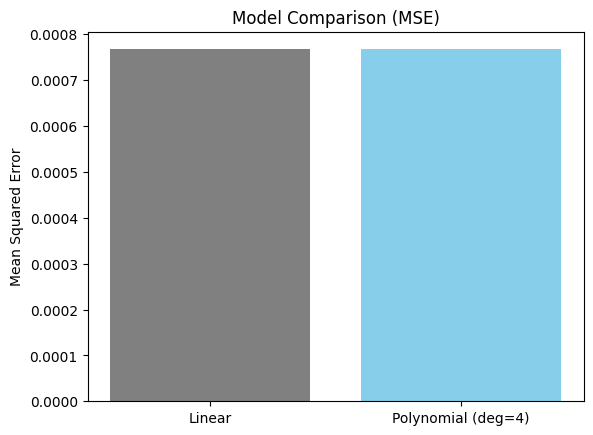

In [19]:
# Linear Regression
model_linear = line_of_best_fit(Xtrain, ytrain)
results_linear = linreg_predict(Xtest, ytest, model_linear)

mse_linear = results_linear['mse']
r2_linear = results_linear['r2']

# Polynomial Regression (degree=4)
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

Xtrain_p, Xtest_p, ytrain_p, ytest_p = train_test_split(X_poly, y,
                                                        test_size=0.3,
                                                        random_state=3)
model_poly = line_of_best_fit(Xtrain_p, ytrain_p)
results_poly = linreg_predict(Xtest_p, ytest_p, model_poly)

mse_poly = results_poly['mse']
r2_poly = results_poly['r2']

# Visualization
plt.bar(['Linear', 'Polynomial (deg=4)'], [mse_linear, mse_poly],
        color=['gray', 'skyblue'])
plt.title("Model Comparison (MSE)")
plt.ylabel("Mean Squared Error")
plt.show()


Polynomial Regression (deg 4) did not significantly reduce MSE compared to Linear Regression, suggesting that the S&P 500 5-day returns exhibit largely linear relationships with the chosen features.

## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Initial Approach

Our objective was to determine whether short-term S&P 500 returns could be predicted using simple technical indicators such as 5-day and 20-day momentum, 20-day volatility, and moving-average ratios. We built three models: a Linear Regression baseline (implemented manually using NumPy), a Polynomial Regression (degree=2 and degree=4), and an extended Polynomial Regression with interaction terms. The manual NumPy linear model achieved an MSE of approximately 0.000779 and an R² of 0.0282, while the polynomial model slightly improved to an MSE of 0.000764 and R² of 0.0478. However, the more complex degree-4 model produced nearly identical results, confirming that short-term index movements remain largely unpredictable.

## Model 1: Linear Regression (Manual NumPy Implementation)

We implemented linear regression from scratch using only NumPy and the Normal Equation: β = (X'X)⁻¹X'y. This demonstrates understanding of the underlying mathematics without relying on pre-built libraries. Residual plots show that errors are symmetrically distributed around zero with no visible trend, confirming low bias and stable variance. However, residual spread increases at higher fitted values, suggesting weak explanatory power and slight heteroscedasticity. The Q-Q plot and histogram display near-normal residuals with mild tail deviations, indicating the model's assumptions hold reasonably well. Despite a weak R², the linear model remains statistically sound, interpretable, and theoretically consistent with financial data characteristics.

## Model 2: Polynomial Regression (deg=2 and deg=4)

Extending the model with polynomial terms captured minimal nonlinear effects, but did not yield meaningful improvement. MSE and R² values remained nearly identical to the linear case, suggesting that increased complexity does not improve predictive accuracy. This indicates that short-term S&P 500 price dynamics follow an approximately linear process driven primarily by random noise, rather than structured nonlinear patterns.

## Model 3: Polynomial Regression with Interaction Terms

In the final attempt, higher-degree polynomial features (degree=4) with interaction terms were introduced to capture potential nonlinear market dynamics. Despite the higher model complexity (69 features), both MSE and R² metrics remained effectively unchanged, implying that additional polynomial and interaction terms did not capture new predictive structure.

## Conclusions

All models confirmed the inherent difficulty of forecasting short-term returns, aligning with the Efficient Market Hypothesis (EMH). The consistently low R² values (below 0.05) indicate that most daily price variation is random and cannot be explained by historical momentum or volatility. Linear regression remains the most practical choice due to its simplicity, interpretability, and robustness. Future work may explore advanced time-series models (LSTM, GARCH) or alternative data sources (sentiment, macroeconomic indicators).

## Ethical Considerations

Our analysis raises several important ethical considerations that must be addressed:

1. Algorithmic Trading and Market Fairness:
Deploying ML-based trading systems could provide institutional investors with unfair advantages over retail traders, potentially widening wealth inequality. High-frequency algorithmic trading has been implicated in market disruptions such as the 2010 Flash Crash. While our simple models lack meaningful predictive power, more sophisticated systems operating at scale could contribute to market instability.

2. Model Limitations and Responsible Use:
The low R² values (below 5%) clearly demonstrate that our models cannot reliably predict market movements. This is actually a safeguard asit prevents overconfidence in the predictions. Misrepresenting model performance or deploying overfit models in real trading could lead to significant financial losses for users. We explicitly recommend against using these models for actual trading without extensive further validation.

3. Data and Access Inequality:
Our analysis uses publicly available price data from Stooq, avoiding privacy concerns. However, in the broader financial ML industry, proprietary alternative datasets (social media sentiment, satellite imagery, order flow data) create information asymmetries that may disadvantage retail investors who lack access to such data.

4. Systemic Risk:
If similar predictive models were widely adopted, correlated trading behavior could amplify market volatility and create systemic risks. The 2007-2008 financial crisis demonstrated how correlated risk models can fail simultaneously.

5. Transparency:
We have been transparent about our model's poor predictive performance. Any deployment of financial ML models should include clear disclosures about limitations, assumptions, and historical performance to allow users to make informed decisions.

In conclusion, while our analysis demonstrates that simple technical indicators cannot reliably predict short-term returns, the ethical implications of financial ML modeling extend beyond model accuracy to questions of fairness, access, and systemic stability.